In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))
log_folder = '/user/work/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'

from dsrnngan.plots import plot_precip, plot_contourf
from dsrnngan.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh



In [3]:
# eval_df = pd.read_csv(os.path.join(log_folder, 'eval_validation.csv'))
# eval_df.head()

In [3]:
with open(os.path.join(log_folder, 'arrays-160000.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = arrays['dates']
hours = arrays['hours']

(n_samples, width, height, ensemble_size) = samples_gen_array.shape

## This is needed until code is fixed

for n in range(fcst_array.shape[0]):
    fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])

In [5]:
# Summary statistics
array_dict = {'IFS': fcst_array, 'iMERG': truth_array, 'cGAN': samples_gen_array}
for k, v in array_dict.items():
    
    print('*'*10)
    print(k)
    print('Mean = ', v.mean())
    print('Max = ', v.max())
    print('Min = ', v.min())
    # print('Median: ', np.median(v))

**********
IFS
Mean =  0.08995985738146559
Max =  44.96231488883496
Min =  0.0
**********
iMERG
Mean =  0.108105086
Max =  111.52867
Min =  0.0
**********
cGAN
Mean =  0.12237558
Max =  500.001
Min =  0.0


In [6]:
# Find dry and rainy days in sampled dataset
means = [(n, truth_array[n,:,:].mean()) for n in range(n_samples)]
sorted_means = sorted(means, key=lambda x: x[1])

n_extreme_days = 10
wet_day_indexes = [item[0] for item in sorted_means[-10:]]
dry_day_indexes = [item[0] for item in sorted_means[:10]]

100%|██████████| 4/4 [00:00<00:00, 15.93it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


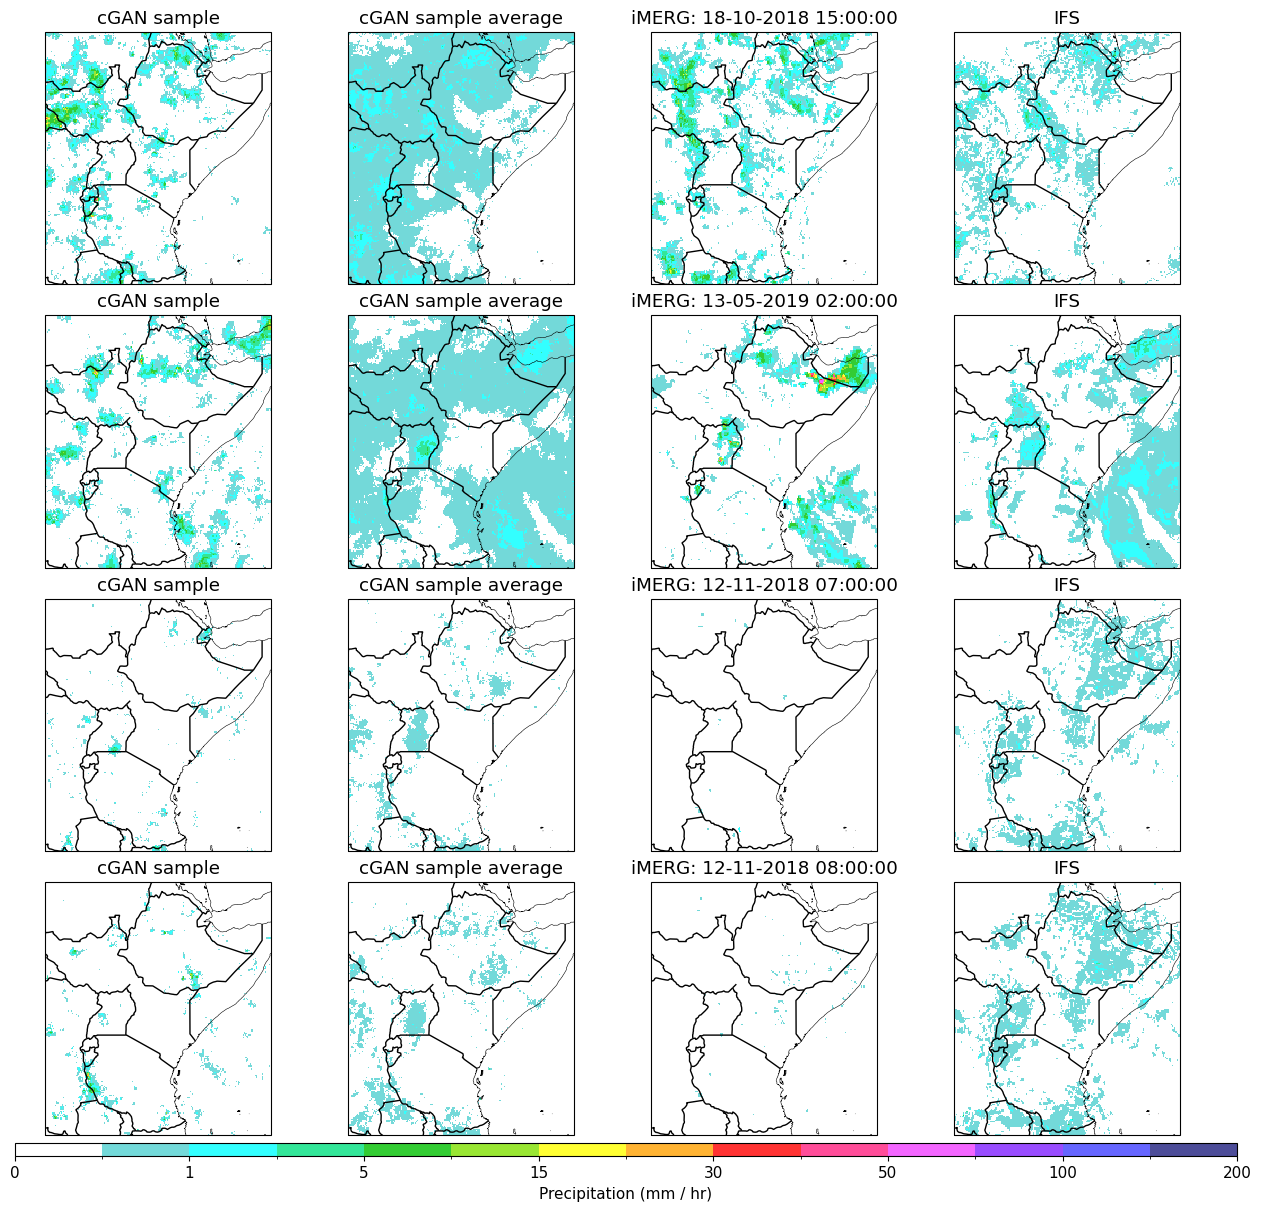

In [60]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

tp_index = data.all_ifs_fields.index('tp')

# plot configurations
levels = [0, 0.1, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200] # in units of log10
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(levels)-1], 'precipitation')
precip_norm = BoundaryNorm(levels, precip_cmap.N)
plt.rcParams.update({'font.size': 11})
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)

indexes = wet_day_indexes[:2] + dry_day_indexes[:2]
num_cols = 5
num_samples = len(indexes)
num_rows = num_samples
# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       width_ratios=[1]*(num_cols - 1) + [0.05],
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)                      
for n in tqdm(range(len(indexes))):

    ix = indexes[n]
    img_gens = samples_gen_array[ix, :,:,:]
    truth = truth_array[ix,:,:]
    fcst = fcst_array[ix,:,:]
    date = dates[ix]
    hour = hours[ix]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date[0].strftime('%d-%m-%Y') + f' {hour[0]:02d}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"iMERG: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        # im = plot_precip(np_array=np.log(val['data']), ax=ax)
        ax.coastlines(resolution='10m', color='black', linewidth=0.4)
        im = ax.imshow(val['data'],
                interpolation='nearest',
                norm=precip_norm,
                cmap=precip_cmap,
                origin='lower',
                extent=[min(DEFAULT_LONGITUDE_RANGE), max(DEFAULT_LONGITUDE_RANGE), 
                  min(DEFAULT_LATITUDE_RANGE), max(DEFAULT_LATITUDE_RANGE)],
                transform=ccrs.PlateCarree(),
                alpha=0.8)
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(val['title'])
        
# precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
# precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[-1, :])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_xlabel("Precipitation (mm / hr)", loc='center')


plt.savefig('cGAN_samples_IFS.eps', format='eps')

In [14]:
rapsd_dict = {k: v for k, v in other_metrics.items() if k.startswith('rapsd')}
crps_dict = {k: v for k, v in other_metrics.items() if k.startswith('CRPS')}

In [16]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE

special_areas = {'lake_victoria': {'lat_range': [-3,1], 'lon_range': [31, 35]},
                 'nairobi': {'lat_range': [-1.5,-1], 'lon_range': [36.5, 37]},
                 'mombasa (coastal)': {'lat_range': [-4.1,-3.9], 'lon_range': [39.5, 39.8]},
                #  'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.6, 7.0], 'lon_range': [39.3, 40.2]},
                 'Butembo / virunga (DRC)': {'lat_range': [-1, 0.5], 'lon_range': [29.0, 29.8]},
                 'Kampala': {'lat_range': [0, 0.6], 'lon_range': [32.1, 32.9]}}

lat_range = [np.round(item, 1) for item in DEFAULT_LATITUDE_RANGE]
lon_range = [np.round(item, 1) for item in DEFAULT_LONGITUDE_RANGE]

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range.index(v['lat_range'][0]), lat_range.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range.index(v['lon_range'][0]), lon_range.index(v['lon_range'][1])]

## Rank histogram

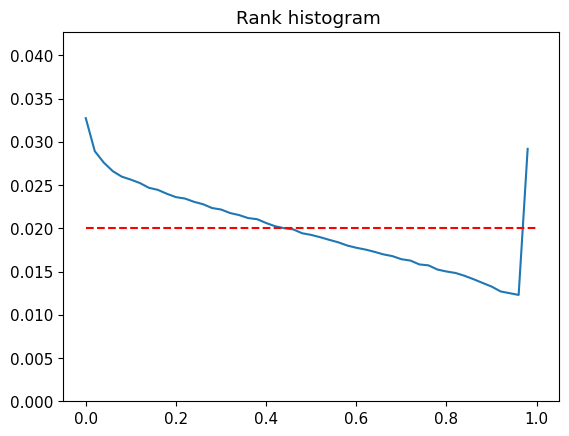

In [12]:
rng = np.random.default_rng()
noise_factor = 1e-6
n_samples = 100

temp_truth = np.repeat(truth_array[:n_samples, :, : ,None].copy(), samples_gen_array.shape[-1], axis=-1)
temp_samples = samples_gen_array[:n_samples, :, :, :].copy()

temp_truth += rng.random(size=temp_truth.shape, dtype=np.float32)*noise_factor
temp_samples += rng.random(size=temp_samples.shape, dtype=np.float32)*noise_factor

ranks = np.sum(temp_truth > temp_samples, axis=-1)

fig, ax = plt.subplots(1,1)
(h, _) = np.histogram(ranks.flatten(), bins=50)
h = h / h.sum()
ax.plot(h)
ax.hlines(1/50, 0, 50, linestyles='dashed', colors=['r'])
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
ax.set_ylim([0, max(h)+0.01])
ax.set_title('Rank histogram ')
plt.savefig('cgan_metrics/rank_hist.png')

# RAPSD

In [13]:
from dsrnngan.rapsd import rapsd

rapsd_truth = []
rapsd_pred = []
rapsd_fcst = []
rapsd_ensmean = []  

for n in tqdm(range(n_samples)):
        fft_freq_pred = rapsd(truth_array[n,:,:], fft_method=np.fft)
        rapsd_truth.append(fft_freq_pred)
        
        fft_freq_pred = rapsd(samples_gen_array[n,:,:,0], fft_method=np.fft)
        rapsd_pred.append(fft_freq_pred)

        fft_freq_fcst = rapsd(fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst.append(fft_freq_fcst)
        
        fft_freq_ensmean = rapsd(ensmean_array[n, :, :], fft_method=np.fft)
        rapsd_ensmean.append(fft_freq_ensmean)

rapsd_truth = np.mean(np.stack(rapsd_truth, axis=-1), axis=-1)
rapsd_pred = np.mean(np.stack(rapsd_pred, axis=-1), axis=-1)
rapsd_fcst = np.mean(np.stack(rapsd_fcst, axis=-1), axis=-1)
rapsd_ensmean = np.mean(np.stack(rapsd_ensmean, axis=-1), axis=-1)

100%|██████████| 100/100 [00:01<00:00, 76.21it/s]


/tmp/ipykernel_445/1709733592.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 200])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


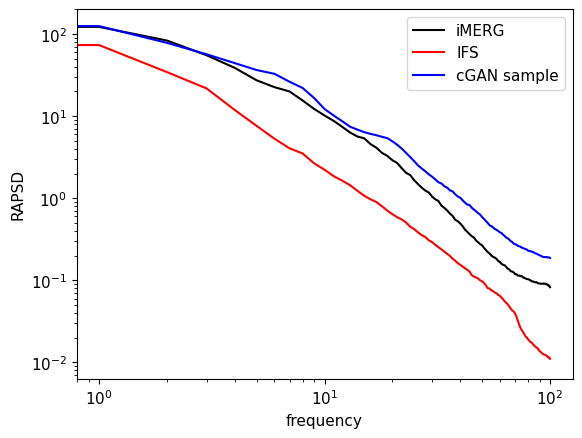

In [14]:
fig, ax = plt.subplots(1,1)

ax.plot(rapsd_truth, label='iMERG', color='k')
ax.plot(rapsd_fcst, 'r', label='IFS')
ax.plot(rapsd_pred, 'b', label='cGAN sample') # Single member of ensemble
plt.xscale('log')
plt.yscale('log')
ax.set_ylim([0, 200])
ax.set_ylabel('RAPSD')
ax.set_xlabel('frequency')
ax.legend()
plt.rcParams.update({'font.size': 14})
plt.savefig('cgan_metrics/rapds.eps', format='eps')

## Histograms

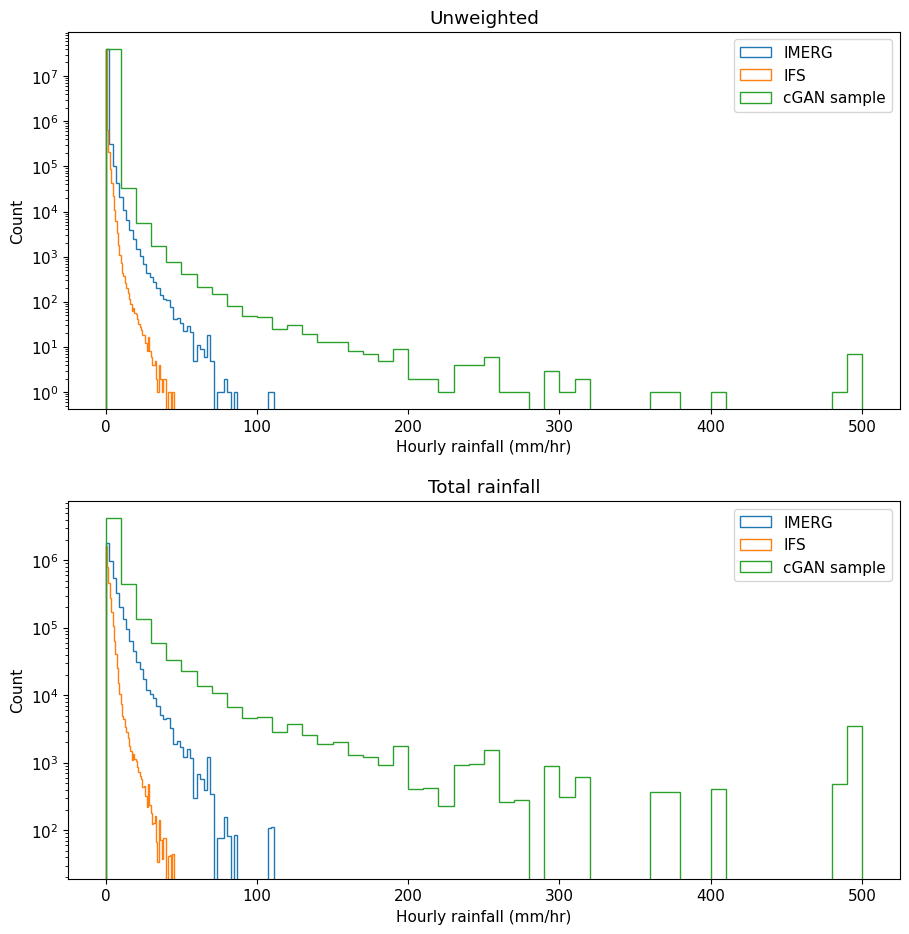

In [61]:
# quantile histograms

fig, axs = plt.subplots(2,1, figsize=(10,10))
fig.tight_layout(pad=4)
num_bins = 50
(bin_count, bin_values) = np.histogram(truth_array.flatten(), bins=num_bins)

axs[0].hist(truth_array.flatten(), bins=num_bins, histtype='step', label='IMERG')
axs[0].hist(fcst_array.flatten(), bins=num_bins, histtype='step', label='IFS')
axs[0].hist(samples_gen_array[:,:,:,0].flatten(), bins=num_bins, histtype='step', label='cGAN sample')
axs[0].set_title('Unweighted')

axs[1].hist(truth_array.flatten(), bins=num_bins, histtype='step',weights=truth_array.flatten(), label='IMERG')
axs[1].hist(fcst_array.flatten(), bins=num_bins, histtype='step', weights=fcst_array.flatten(), label='IFS')
axs[1].hist(samples_gen_array[:,:,:,0].flatten(), bins=num_bins, histtype='step', weights=samples_gen_array[:,:,:,0].flatten(), label='cGAN sample')#
axs[1].set_title('Total rainfall')

for ax in axs:
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Hourly rainfall (mm/hr)')
    ax.set_ylabel('Count')


## Quantiles

In [64]:
number_in_top_range = 10000
quantile_boundaries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] + list(np.linspace(0.9, 1.0, number_in_top_range))
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)
print('Number data points per quantile in top range: ', 0.1*len(truth_array.flatten()) / number_in_top_range)
print('percentile steps in top range: ', 10 / number_in_top_range)

Number data points per quantile in top range:  402.0
percentile steps in top range:  0.001


In [ ]:
# Peter's code for doing quantiles:

#List of percentiles to plot in the middle of the distribution (more extreme percentiles are derived from the data)
#The percentiles in each element of the list are plotted with different symbols
#every tenth between 10th to 90th and every 1 between 1st-5th and 95th-99th (similar to Guillod et al., 2016, fig.11).
percentiles_list_middle=[np.arange(0.1,1.,0.1),
                            np.arange(1,5.1,1),
                            np.arange(10,91,10),
                            np.arange(95,99.1,1),
                            np.arange(99.1,99.91,0.1)]

#Get percentiles to plot for more extreme points - plot the percentiles corresponding to each point for the smallest dataset if there are fewer than 100 beyond the 0.1th or 99.9th percentiles, else select up to 100 with even spacing. The most extreme points (0th and 100th percentiles) are not included, since this depends on the dataset size, so isn't easy to fairly compare in general. 
n_pts = truth_array.shape[0]

min_interval=100./(n_pts-1) #the top 0.1th percentile divided by the top 0.1% of datapoints (0.1/0.001=100)
if 0.001*n_pts<=100:
    interval=min_interval
else:
    interval=min_interval*np.ceil(0.01*n_pts/100.)
pcs_first=np.arange(min_interval,0.1,interval)

percentiles_list=[pcs_first]+percentiles_list_middle+[100-pcs_first[::-1]]
percentiles=np.concatenate(percentiles_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


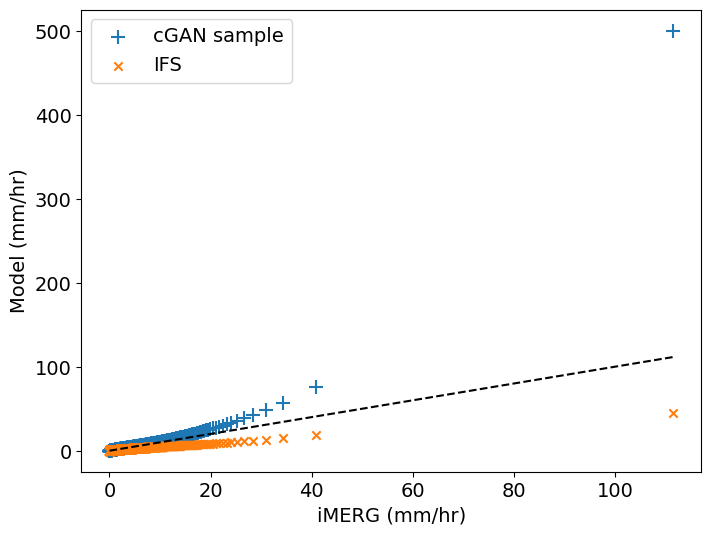

In [65]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

max_fcst_val = max(max(sample_quantiles), max(fcst_quantiles))
max_truth_val = max(truth_quantiles)
ax.scatter(truth_quantiles, sample_quantiles, marker='+', label='cGAN sample', s=100)
ax.scatter(truth_quantiles, fcst_quantiles, marker='x', label='IFS')
# plt.xscale('log')
# plt.yscale('log')
ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('iMERG (mm/hr)')
ax.set_ylabel('Model (mm/hr)')

plt.rcParams.update({'font.size': 14})
ax.legend()
plt.savefig('cgan_metrics/quantiles_total.eps', format='eps')

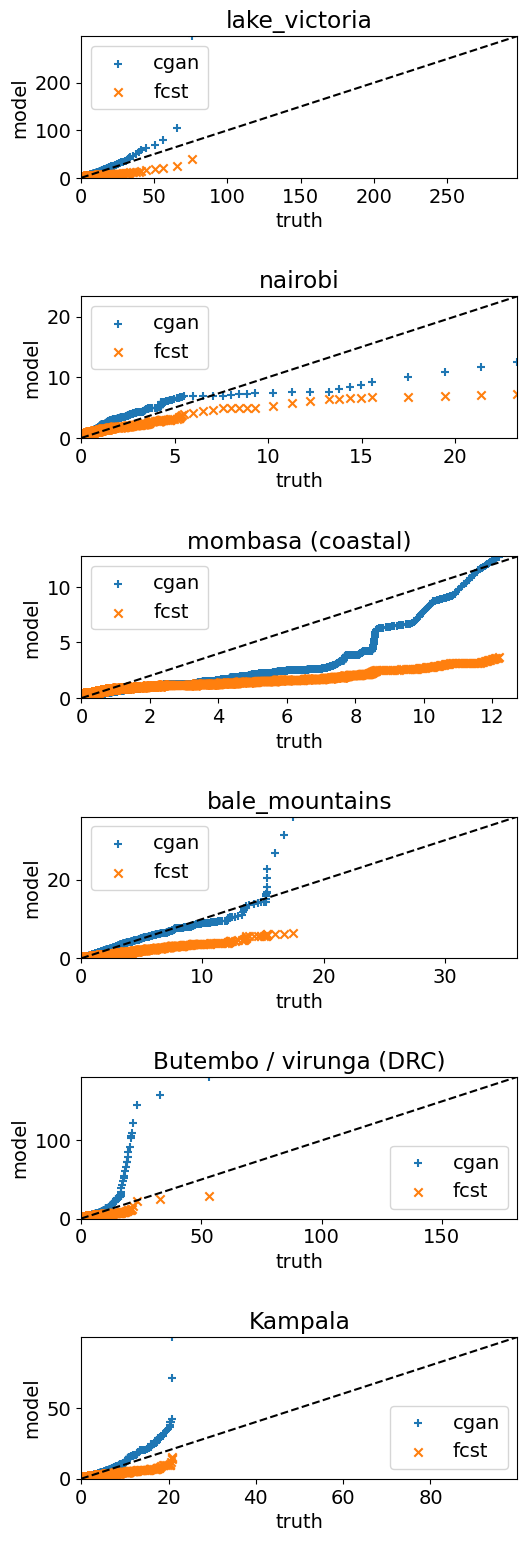

In [66]:
# Quantiles for different areas

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(6, 16))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    max_val = max(max(truth_quantiles), max(sample_quantiles), max(fcst_quantiles))
    
    ax[n].scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
    ax[n].scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
    ax[n].plot(np.arange(0,max_val, 0.01), np.arange(0,max_val, 0.01), 'k--')
    ax[n].set_xlabel('truth')
    ax[n].set_ylabel('model')
    ax[n].set_title(area)
    ax[n].set_xlim([-0.01, max_val + 0.01])
    ax[n].set_ylim([-0.01, max_val + 0.01])
    ax[n].legend()
    
fig.tight_layout(pad=2.0)
plt.savefig('cgan_metrics/quantiles_area.png')

## Grid metrics

In [41]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE


In [45]:
# RMSE
rmse_dict = {'single_sample_rmse': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'ensmean_rmse' : np.sqrt(np.mean(np.square(truth_array - np.mean(samples_gen_array, axis=-1)), axis=0)),
            'fcst_rmse' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0))}

lat_range=DEFAULT_LATITUDE_RANGE
lon_range=DEFAULT_LONGITUDE_RANGE

In [58]:
import pickle

with open('/user/home/uz22147/repos/downscaling-cgan/rainfall_data/daily_imerg_rainfall_2018.pkl', 'rb') as ifh:
    daily_imerg_rainfall = pickle.load(ifh)

In [75]:

# Need to get data for earlier periods as well
all_arrays = []
for month, day_vals in daily_imerg_rainfall.items():
     for day, daily_sum in day_vals.items():
         all_arrays.append(daily_sum)
historical_daily_truth_data = np.stack(all_arrays, axis=-1)
daily_historical_avg = np.mean(historical_daily_truth_data, axis=-1)
daily_historical_std = np.std(historical_daily_truth_data, axis=-1)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

In [73]:
# Get longer term truth std and avg
# import xarray as xr
# from calendar import monthrange

# imerg_monthly_folder = '/bp1/geog-tropical/users/uz22147/east_africa_data/IMERG/monthly'

# year = 2020
# month = 12

# all_arrays = []
# for year in range(2001, 2018):
#     for month in range(1,13):
#         n_days = monthrange(year, month)[1]
#         ds = xr.load_dataset(os.path.join(imerg_monthly_folder, f'{year}{month:02d}_total.nc'))
#         ds = ds.sel(lat=DEFAULT_LATITUDE_RANGE).sel(lon=DEFAULT_LONGITUDE_RANGE)

#         all_arrays.append(ds['precipitationCal'][0,:,:]/ (n_days*24)) # divide by number of hours in month
        
# historical_truth_data = np.stack(all_arrays, axis=-1)

# truth_historical_avg = np.mean(historical_truth_data, axis=-1).transpose()
# truth_historical_std = np.std(historical_truth_data, axis=-1).transpose()

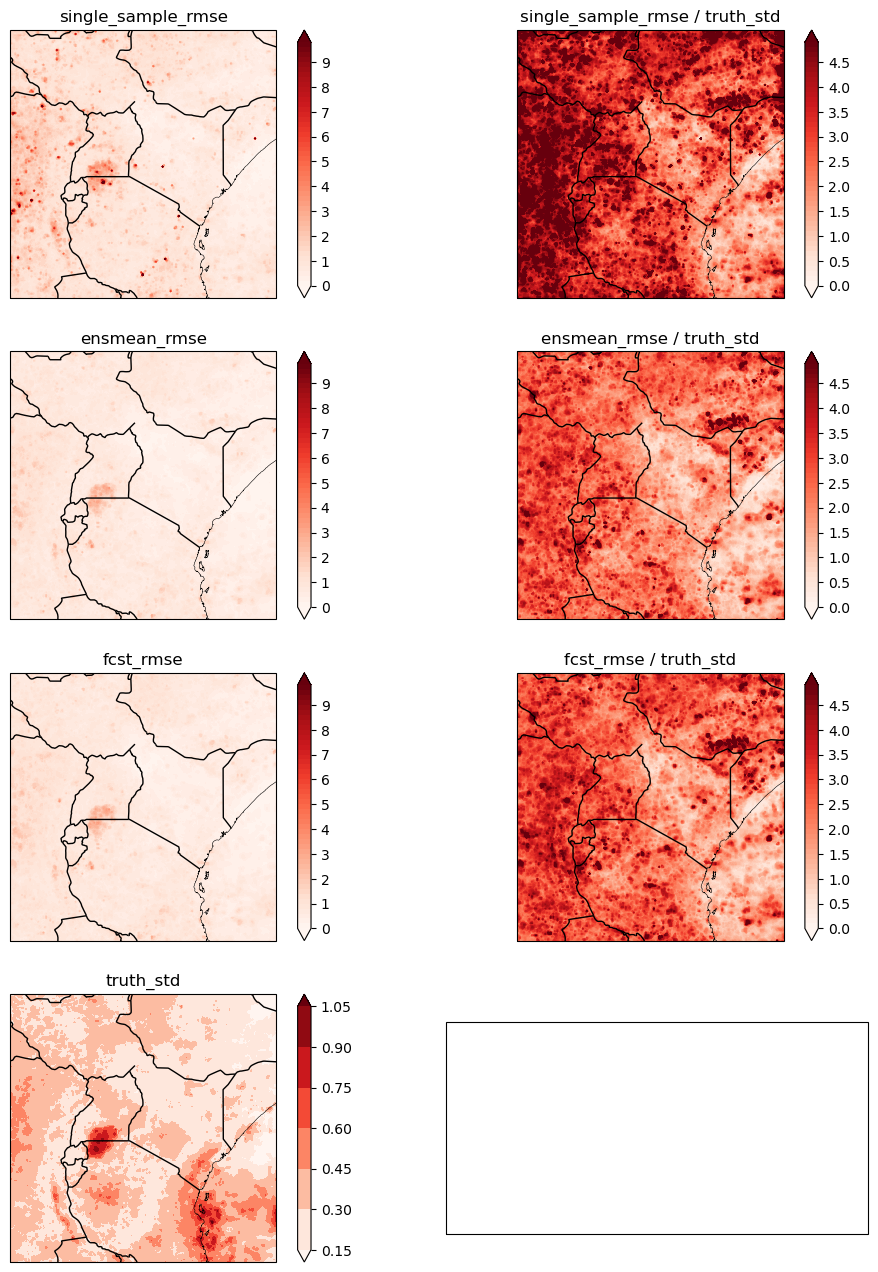

In [72]:
# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf(ax[n,0], v, title=k, value_range=value_range, lat_range=lat_range, lon_range=lon_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf(ax[n,1], v / hourly_historical_std, title=k + ' / truth_std', value_range=value_range_2 , lat_range=lat_range, lon_range=lon_range)
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf(ax[n+1,0], hourly_historical_std, title='truth_std', lat_range=lat_range, lon_range=lon_range)
plt.colorbar(im, ax=ax[n+1,0])

# plt.savefig('cgan_metrics/rmse.png')


In [56]:
# bias
bias_dict = {'single_sample_bias': np.mean(samples_gen_array[:,:,:,0] - truth_array, axis=0),
            'ensmean_bias' : np.mean(ensmean_array - truth_array, axis=0),
            'fcst_bias' : np.mean(fcst_array - truth_array, axis=0)}

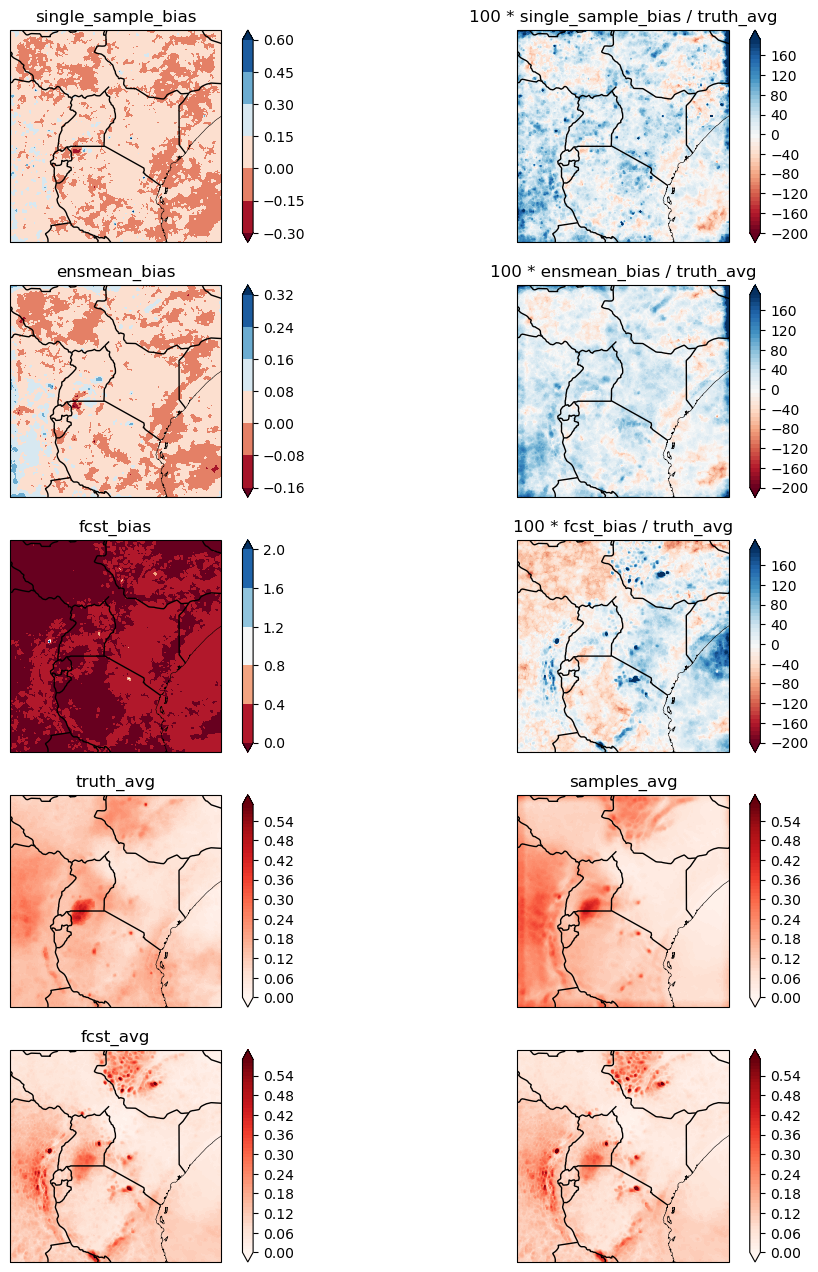

In [74]:
lat_range=np.arange(-10.05, 10.05, 0.1)
lon_range=np.arange(25.05, 45.05, 0.1)
fig, ax = plt.subplots(len(bias_dict.keys())+2,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_bias_val = max([v.max() for v in bias_dict.values()])

for n, (k,v) in enumerate(bias_dict.items()):


    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    im = plot_contourf(ax[n,0], v, title=k, cmap='RdBu', value_range=value_range, lat_range=lat_range, lon_range=lon_range)
    plt.colorbar(im, ax=ax[n,0])
    
    im = plot_contourf(ax[n,1], 100* v / hourly_historical_avg, title=f'100 * {k} / truth_avg', value_range=list(np.arange(-200, 200, 400 / 50)),
                       cmap='RdBu', lat_range=lat_range, lon_range=lon_range)
    plt.colorbar(im, ax=ax[n,1])
    
im = plot_contourf(ax[n+1,0], hourly_historical_avg, title='truth_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=lat_range, lon_range=lon_range)
plt.colorbar(im, ax=ax[n+1,0])

im = plot_contourf(ax[n+1,1], np.mean(np.mean(samples_gen_array, axis=-1), axis=0), title='samples_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=lat_range, lon_range=lon_range)
plt.colorbar(im, ax=ax[n+1,1])

im = plot_contourf(ax[n+2,0], np.mean(fcst_array, axis=0), title='fcst_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=lat_range, lon_range=lon_range)
plt.colorbar(im, ax=ax[n+2,0])

im = plot_contourf(ax[n+2,1], np.mean(fcst_array, axis=0), title='', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=lat_range, lon_range=lon_range)
plt.colorbar(im, ax=ax[n+2,1])

plt.savefig('cgan_metrics/bias.png')


## CRPS

In [8]:
from properscoring import crps_ensemble

# crps_ensemble expects truth dims [N, H, W], pred dims [N, H, W, C]
crps_score_grid = crps_ensemble(truth_array, samples_gen_array)
crps_score = crps_score_grid.mean()

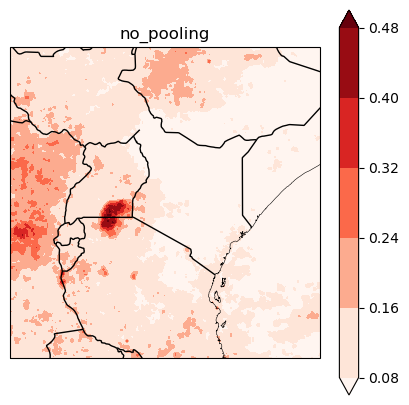

In [20]:
fig, ax = plt.subplots(1, 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(5,5))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

im = ax.contourf(DEFAULT_LONGITUDE_RANGE, DEFAULT_LATITUDE_RANGE, np.mean(crps_score_grid, axis=0), transform=ccrs.PlateCarree(),
                    cmap='Reds', 
                    # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')

ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
ax.set_title(k)
plt.colorbar(im, ax=ax)
plt.savefig('cgan_metrics/crps.png')


## Scatter plots

In [68]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [69]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

KeyboardInterrupt: 

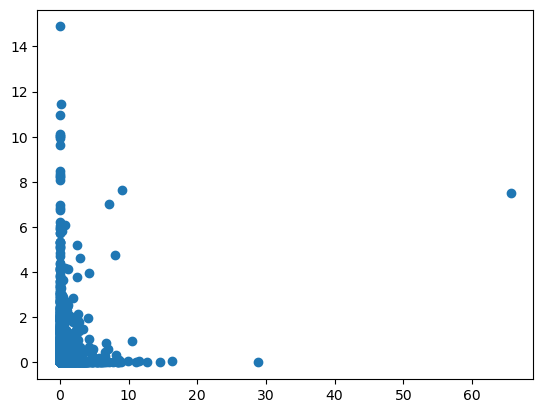

In [ ]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

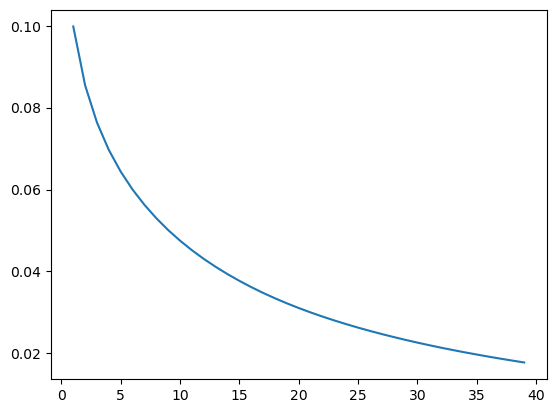

In [108]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

In [4]:
from dsrnngan.scoring import fss
from tqdm import tqdm


window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
daily_thresholds = [1, 5, 20, 30, 50] # 1mm/day = drizzle, 50 mm/day = extreme

fss_cgan = []
fss_fcst = []
fss_ensmean = []

for thr in daily_thresholds:

    tmp_fss_cgan = []
    tmp_fss_fcst = []
    tmp_fss_ensmean = []

    for w in tqdm(window_sizes):
        
        tmp_fss_cgan.append(fss(truth_array, samples_gen_array, w, thr/24.0, mode='constant'))
        tmp_fss_fcst.append(fss(truth_array, fcst_array, w, thr/24.0, mode='constant'))
        tmp_fss_ensmean.append(fss(truth_array, ensmean_array, w, thr/24.0, mode='constant'))
    
    fss_cgan.append(tmp_fss_cgan)
    fss_fcst.append(tmp_fss_fcst)
    fss_ensmean.append(tmp_fss_ensmean)

100%|██████████| 17/17 [05:39<00:00, 19.98s/it]


NameError: name 'daily_thresholds' is not defined

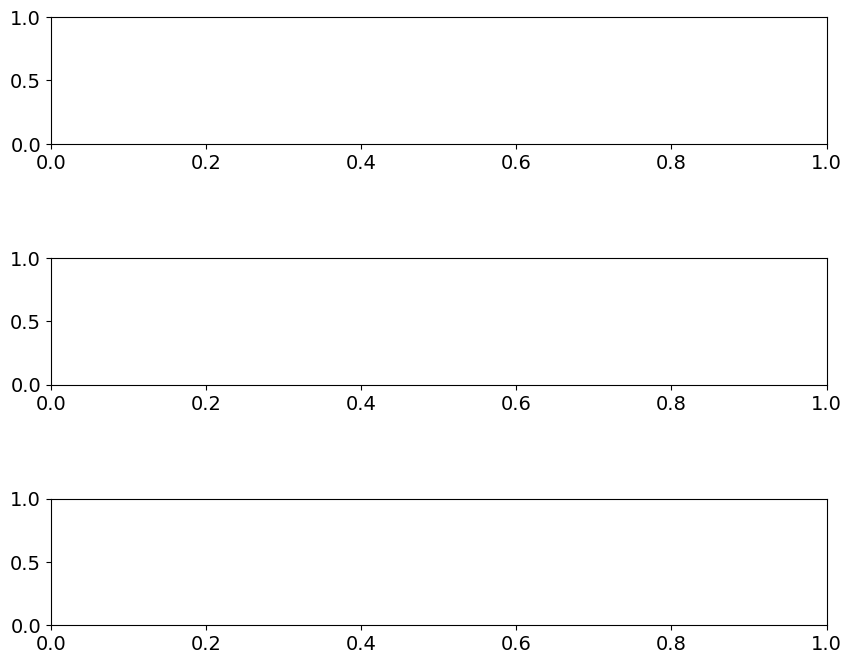

In [70]:
fig, axs = plt.subplots(3, 1, figsize = (10, 8))
fig.tight_layout(pad=4.0)
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]

for n, thr in enumerate(daily_thresholds):
    
    axs[0].plot(window_sizes, [item for item in fss_cgan[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    # axs[1].plot(window_sizes, [item for item in fss_ensmean[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[1].plot(window_sizes, [item for item in fss_fcst[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])

    axs[0].set_title('cGAN sample')
    # axs[1].set_title('Ensemble mean')
    axs[1].set_title('IFS fcst')

for ax in axs:    
    ax.hlines(0.5, 0, max(window_sizes), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size')
    ax.set_ylabel('FSS')
    ax.legend()
    
plt.savefig('cgan_metrics/fractional_skill_score.png')

# Plot to compare cgan and IFS directly


## Diurnal cycle

In [10]:
hourly_data_obs = {}
hourly_data_sample = {}
hourly_data_fcst = {}
hourly_counts = {}

for n in tqdm(range(n_samples)):
    obs = truth_array[n,:,:]
    sample = samples_gen_array[n,:,:,0]
    fcst = fcst_array[n, :, :]
    hour = hours[n][0]
    
    if hour not in hourly_data_obs:
        hourly_data_obs[hour] = obs
        hourly_data_sample[hour] = sample
        hourly_data_fcst[hour] = fcst
        hourly_counts[hour] = 1
    else:
        hourly_data_obs[hour] += obs
        hourly_data_sample[hour] += sample
        hourly_data_fcst[hour] += fcst
        hourly_counts[hour] += 1
    
        

    

100%|██████████| 1000/1000 [00:03<00:00, 302.75it/s]


Text(0, 0.5, 'Average mm/hr')

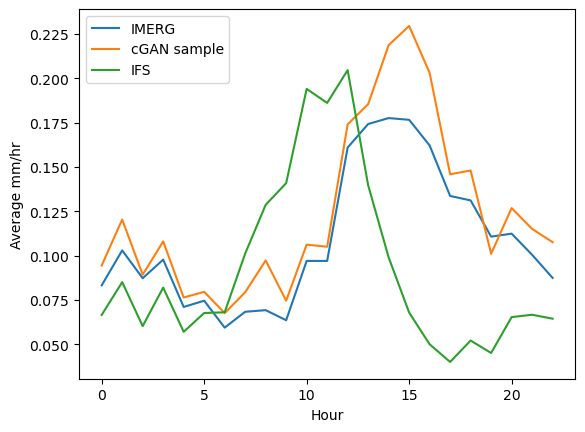

In [13]:
# Plot diurnal cycle

fig, ax = plt.subplots(1,1)
diurnal_data_dict = {'IMERG': hourly_data_obs,
                     'cGAN sample': hourly_data_sample,
                     'IFS': hourly_data_fcst}

for name, data in diurnal_data_dict.items():
    
    mean_hourly_data = [np.mean(data[n] / hourly_counts[n]) for n in range(23)]
    
    ax.plot(mean_hourly_data, label=name)
    
ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')      

100%|██████████| 1000/1000 [00:00<00:00, 77427.11it/s]


{20: 42, 16: 41, 6: 39, 17: 48, 9: 45, 14: 45, 19: 49, 0: 53, 11: 35, 22: 37, 4: 42, 2: 40, 18: 44, 1: 44, 13: 40, 15: 42, 5: 42, 12: 39, 10: 43, 7: 43, 3: 34, 23: 43, 8: 36, 21: 34}


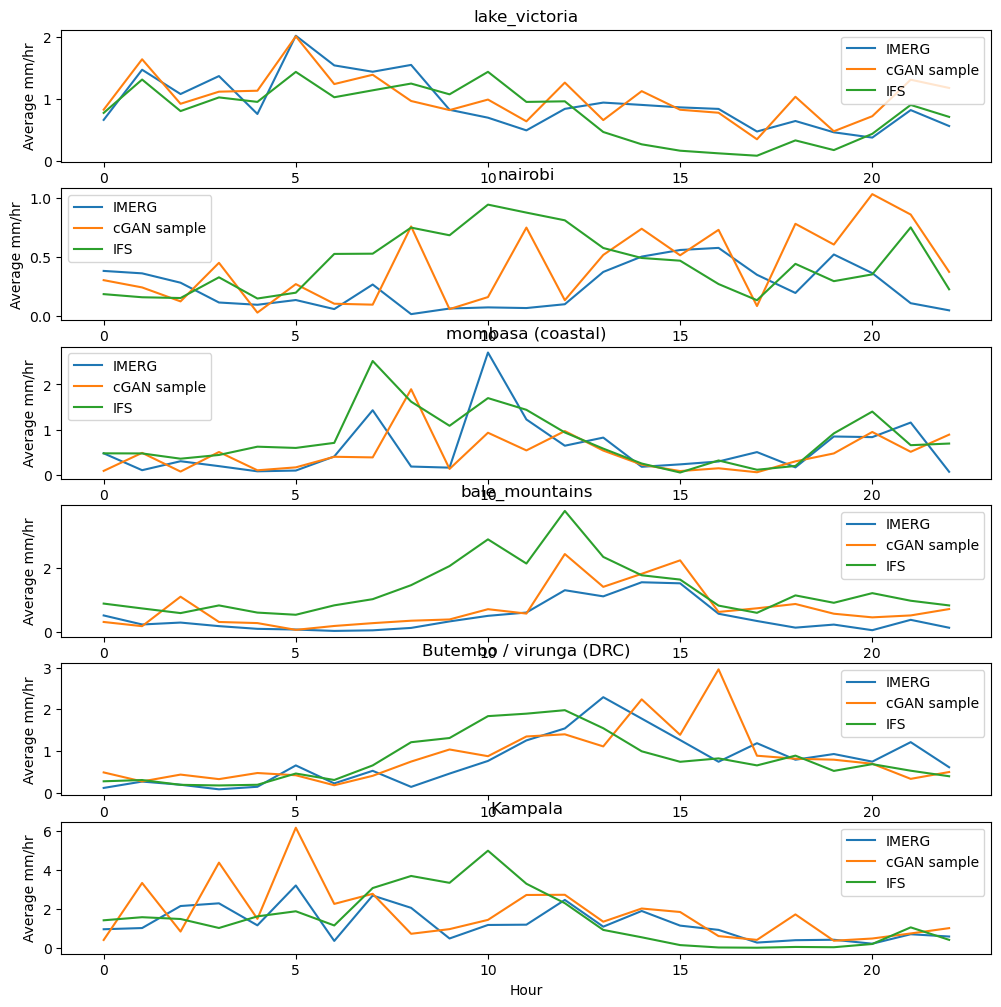

In [35]:
# Diurnal cycles for different areas

hourly_area_data_obs = {}
hourly_area_data_sample = {}
hourly_area_data_fcst = {}
hourly_counts = {}
for n, (area, area_range) in enumerate(special_areas.items()):

    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    
    hourly_area_data_obs[area] = {}
    hourly_area_data_sample[area] = {}
    hourly_area_data_fcst[area] = {}
    hourly_counts = {}

    for n in tqdm(range(n_samples)):
        obs = truth_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        sample = samples_gen_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1],0]
        fcst = fcst_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        hour = hours[n][0]
        
        if hour not in hourly_area_data_obs[area]:
            hourly_area_data_obs[area][hour] = obs
            hourly_area_data_sample[area][hour] = sample
            hourly_area_data_fcst[area][hour] = fcst
            hourly_counts[hour] = 1
        else:
            hourly_area_data_obs[area][hour] += obs
            hourly_area_data_sample[area][hour] += sample
            hourly_area_data_fcst[area][hour] += fcst
            hourly_counts[hour] += 1
print(hourly_counts)

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(special_areas),1, figsize=(12,12))
diurnal_data_dict = {'IMERG': hourly_area_data_obs,
                     'cGAN sample': hourly_area_data_sample,
                     'IFS': hourly_area_data_fcst}
# TODO: get errorbars on this
for n, area in enumerate(special_areas):
    for name, data in diurnal_data_dict.items():
        grid_average = [data[area][n] / hourly_counts[n] for n in range(23)]
        mean_hourly_data = [np.mean(data[area][n] / hourly_counts[n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(area)

100%|██████████| 1000/1000 [00:00<00:00, 1698.84it/s]


{16: 12, 6: 10, 14: 10, 22: 11, 13: 12, 15: 8, 12: 12, 0: 12, 4: 9, 18: 11, 1: 8, 19: 15, 23: 12, 8: 9, 9: 11, 10: 12, 7: 11, 17: 9, 3: 6, 11: 8, 21: 12, 2: 8, 5: 7, 20: 7}


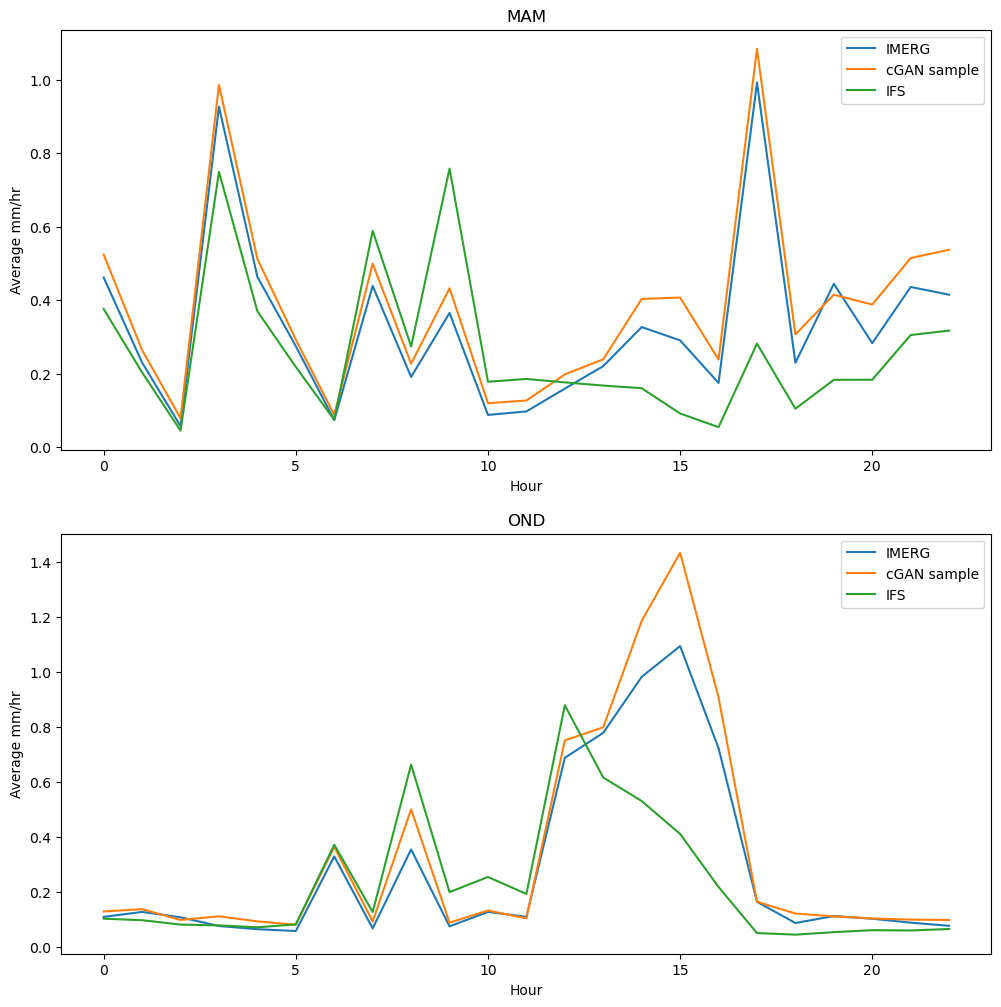

In [33]:
# Diurnal cycle for different seasons

from collections import Counter

seasons_dict = {'MAM': [3,4,5], 'OND': [10,11,12]}

hourly_season_data_obs = {}
hourly_season_data_sample = {}
hourly_season_data_fcst = {}
hourly_counts = {}
for n, (season, month_range) in enumerate(seasons_dict.items()):
    
    hourly_season_data_obs[season] = {}
    hourly_season_data_sample[season] = {}
    hourly_season_data_fcst[season] = {}
    hourly_counts = {}

    for n in tqdm(range(n_samples)):
        obs = truth_array[n, :, :]
        sample = samples_gen_array[n, :,:,0]
        fcst = fcst_array[n, :,:]
        hour = hours[n][0]
        date = dates[n][0]
        
        if date.month in month_range:
            if hour not in hourly_season_data_obs[season]:
                hourly_season_data_obs[season][hour] = obs
                hourly_season_data_sample[season][hour] = sample
                hourly_season_data_fcst[season][hour] = fcst
                hourly_counts[hour] = 1
            else:
                hourly_season_data_obs[season][hour] += obs
                hourly_season_data_sample[season][hour] += sample
                hourly_season_data_fcst[season][hour] += fcst
                hourly_counts[hour] += 1

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(seasons_dict),1, figsize=(12,12))
diurnal_data_dict = {'IMERG': hourly_season_data_obs,
                     'cGAN sample': hourly_season_data_sample,
                     'IFS': hourly_season_data_fcst}
print(hourly_counts)
for n, season in enumerate(seasons_dict):
    for name, data in diurnal_data_dict.items():
        
        mean_hourly_data = [np.mean(data[season][n] / hourly_counts[n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(season)

## Check locations of maximum rainfall

In [9]:
max_samples_gen = np.max(np.max(samples_gen_array, axis=-1), axis=0)
max_truth = np.max(truth_array, axis=0)

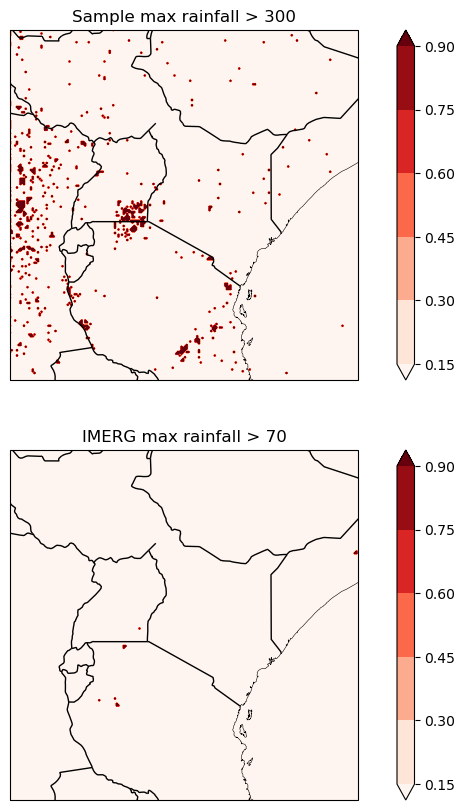

In [29]:
fig, ax = plt.subplots(2,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))
threshold = 300
im = plot_contourf(ax[0], (max_samples_gen > threshold), title=f'Sample max rainfall > {threshold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=DEFAULT_LONGITUDE_RANGE)
plt.colorbar(im, ax=ax[0])

obs_thresold = 70
im = plot_contourf(ax[1], (max_truth > obs_thresold), title=f'IMERG max rainfall > {obs_thresold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=DEFAULT_LONGITUDE_RANGE)
plt.colorbar(im, ax=ax[1])

## Check training data for high rainfall

In [76]:
# Check range of values in training data
from dsrnngan.tfrecords_generator import create_mixed_dataset, DataGenerator

train = DataGenerator('train',
                           batch_size=1,
                           fcst_shape=(200, 200, 20),
                            con_shape=(200, 200, 2),
                            out_shape=(200, 200, 1),
                           downsample=False, 
                           weights=[0.4, 0.3, 0.2, 0.1], 
                           records_folder='/user/work/uz22147/tfrecords/d34d309eb0e00b04', 
                           )



2023-02-03 14:09:19.309283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/work/uz22147/miniconda3/lib/
2023-02-03 14:09:19.309392: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 14:09:19.309440: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bp1-login01.data.bp.acrc.priv): /proc/driver/nvidia/version does not exist
2023-02-03 14:09:19.310941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [93]:
from tqdm import tqdm
from dsrnngan.data import denormalise

max_rainfall = 0
take_n = 20000

for a in tqdm(train.take(take_n).as_numpy_iterator()):
    ifs_input = a[0]['lo_res_inputs']
    imerg_output = a[1]['output']
    
    if denormalise(imerg_output.max()) > max_rainfall:
        max_rainfall = denormalise(imerg_output.max())

20000it [00:35, 555.92it/s]


In [95]:
max_rainfall

105.64359813259901

In [177]:
!zip -r cgan_metrics.zip cgan_metrics

updating: cgan_metrics/ (stored 0%)
updating: cgan_metrics/fractional_skill_score.png (deflated 8%)
updating: cgan_metrics/bias.png (deflated 2%)
updating: cgan_metrics/quantiles_total.png (deflated 15%)
updating: cgan_metrics/rank_hist.png (deflated 16%)
updating: cgan_metrics/quantiles_area.png (deflated 21%)
updating: cgan_metrics/rmse.png (deflated 2%)
updating: cgan_metrics/rapds.png (deflated 6%)
updating: cgan_metrics/crps.png (deflated 10%)
  adding: cgan_metrics/cGAN_samples_IFS.png (deflated 6%)
